In [4]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D # , P2, P2_tf
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_zy_plt
from util_kitti import draw_corner_2D, draw_birdeyes, set_bev_background

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2
import pickle 
from scipy.optimize import fsolve
import glob
from scipy.optimize import curve_fit
import math

IS_SIDE_CHANNEL = False
N_ANCHOR_PER_PIXEL = 32 # 36 # 32
ANCHOR_NAME = 'anchors_adaptive' # 'anchors_adaptive' 'anchors_adaptive_Yoffset'

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"

labels = []
for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1])
    
    for label in kitti_label_file_parser(fn, tf_matrix= P2_label):
        # filter labal via gac_original's critiria
        if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
            continue
        else:
            labels.append(label)

# Get function

(z, N, std) = (5, (655, 0.10501327372319122))
3.9844274809160307
0.5718209300460175
(z, N, std) = (15, (4743, 0.16719968608544322))
10.147990723170988
2.8152414739278906
(z, N, std) = (25, (4719, 0.27470888212677436))
20.122091544818815
2.914793327724387
(z, N, std) = (35, (4009, 0.40231300841187473))
29.91402594163133
2.8876151030068935
(z, N, std) = (45, (3089, 0.49893546025659))
39.71047911945613
2.8460715907732888
(z, N, std) = (55, (2281, 0.5679946494421548))
49.55971942130645
2.846846846325111
(z, N, std) = (65, (1098, 0.5897827568996037))
59.49427140255009
2.855021311893832
(z, N, std) = (75, (579, 0.6298068378280947))
69.61511226252158
2.7228568976631653
(z, N, std) = (85, (117, 0.5042078184077206))
77.47829059829058
1.804882878790456
(z, N, std) = (95, (1, 0.0))
86.18
0.0
popt_upper = [-6.36049643e-10  1.79487634e-07 -1.84652682e-05  7.35792610e-04
  4.99605174e-05  1.82778421e+00]
popt_lower = [ 6.36057205e-10 -1.79489392e-07  1.84654126e-05 -7.35797520e-04
 -4.99011531e-05  

/home/lab530/anaconda3/envs/KenYuGAC/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/lab530/anaconda3/envs/KenYuGAC/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


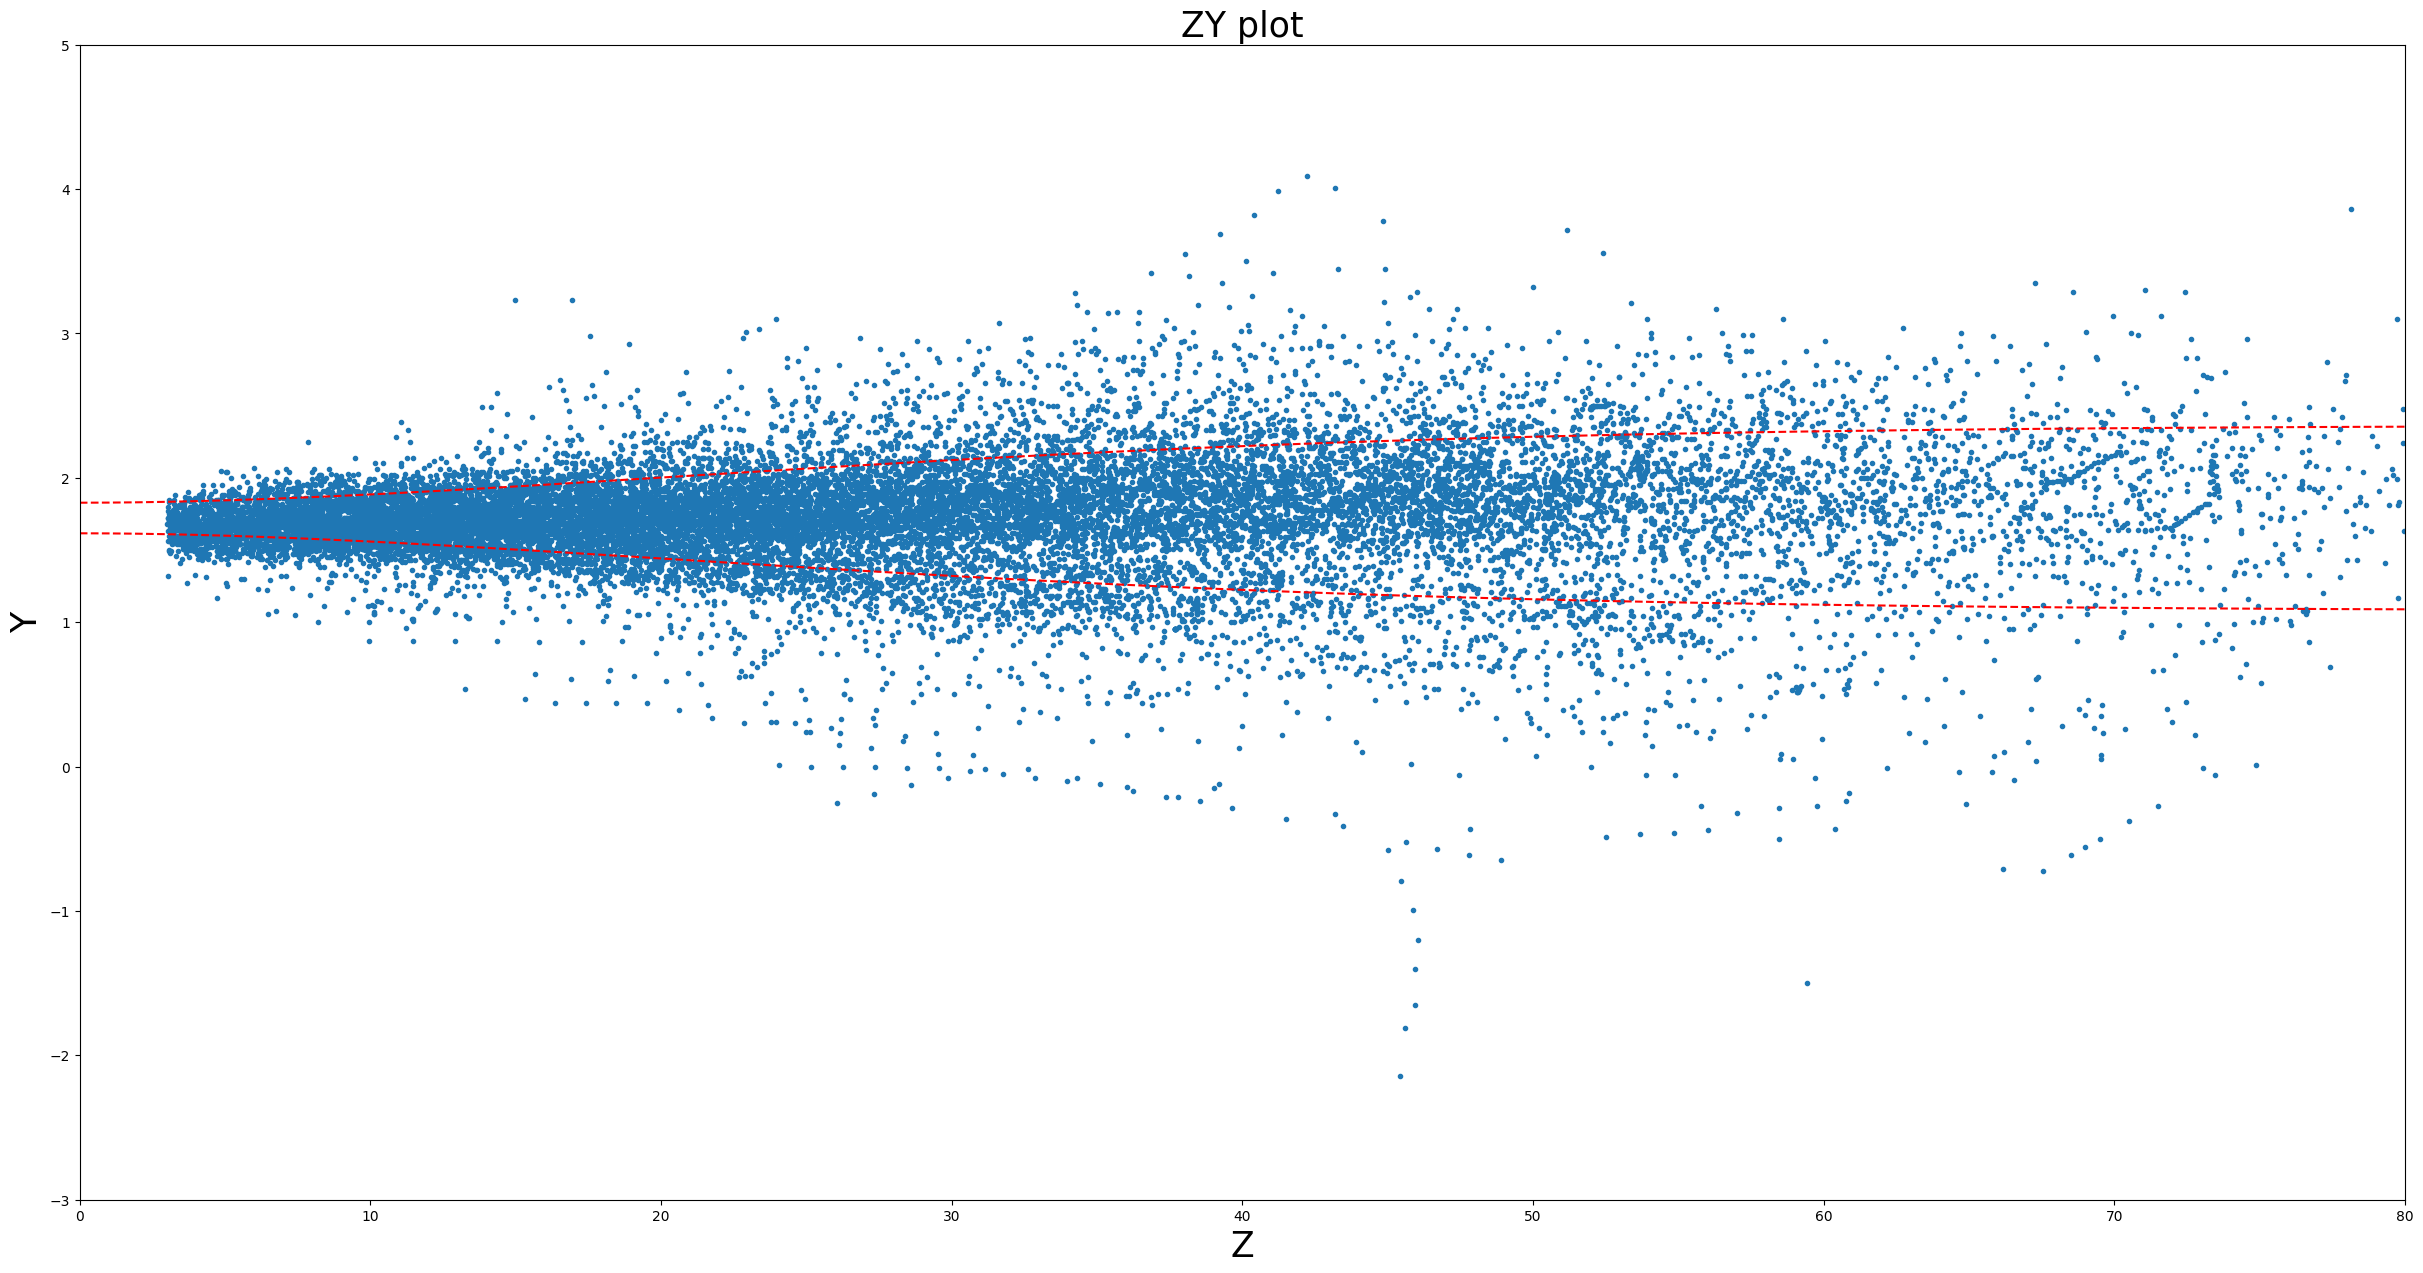

In [8]:
axs = init_zy_plt(["ZY plot"])

# Show y_3d
gt_scatter = [[], []] # [[z,...], [y, ....]]
for obj in labels:
    gt_scatter[0].append(obj.z3d)
    gt_scatter[1].append(obj.y3d)
    # plt.plot(obj.z_3d, obj.y_3d, '.', color = color_dic[obj.idx_img])
gt_scatter[0] = np.array( gt_scatter[0] )
gt_scatter[1] = np.array( gt_scatter[1] )
axs[0].plot(gt_scatter[0], gt_scatter[1], '.')
y_mean = np.mean(gt_scatter[1])

bin_y_s = [[] for i in range(10)] # 10 bins
bin_z_s = [[] for i in range(10)] # 10 bins
for i, z in enumerate(gt_scatter[0]):
    try:
        bin_y_s[int( round(z/10) )].append(gt_scatter[1][i])
    except Exception:
        pass
    try:
        bin_z_s[int( round(z/10) )].append(z)
    except Exception:
        pass
bin_y_s = np.array([np.array(i) for i in bin_y_s])
bin_z_s = np.array([np.array(i) for i in bin_z_s])

bin_y_std = []
y_upper_bound = []
y_lower_bound = []
for i_bin, bin_y in enumerate(bin_y_s):
    print(f"(z, N, std) = {i_bin*10 + 5, (len(bin_y), np.std(bin_y))}")
    print(f"{np.mean(bin_z_s[i_bin])}")
    print(f"{np.std(bin_z_s[i_bin])}")
    
    if len(bin_y) > 500:
        y_upper_bound.append(y_mean + 1*np.std(bin_y))
        y_lower_bound.append(y_mean - 1*np.std(bin_y))
        bin_y_std.append(np.std(bin_y))
    else: # Ignore bin with less with 1000 points
        y_upper_bound.append(y_upper_bound[-1])
        y_lower_bound.append(y_lower_bound[-1])
        bin_y_std.append(np.std(bin_y_std[-1]))

# plt.plot(z_list, y_upper_bound, '-')
# plt.plot(z_list, y_lower_bound, '-')

## Curve Fitting
def func(x, a, b, c, d, e ,f):
    return a*(x**5) + b*(x**4) + c*(x**3) + d*(x**2) + e*(x**1) + f
popt_upper, _ = curve_fit(func, np.arange(0, 100, 10), y_upper_bound)
popt_lower, _ = curve_fit(func, np.arange(0, 100, 10), y_lower_bound)
# popt, _ = curve_fit(func, np.arange(0, 100, 10), bin_y_std)

print(f"popt_upper = {popt_upper}")
print(f"popt_lower = {popt_lower}")

# Upper and lower bound
axs[0].plot(list(range(0, 100)), [func(i, *popt_upper) for i in range(0, 100)], 'r--')
axs[0].plot(list(range(0, 100)), [func(i, *popt_lower) for i in range(0, 100)], 'r--')

(z, N, std) = (5, (655, 0.10501327372319122))
(z, N, std) = (15, (4743, 0.16719968608544322))
(z, N, std) = (25, (4719, 0.27470888212677436))
(z, N, std) = (35, (4009, 0.40231300841187473))
(z, N, std) = (45, (3089, 0.49893546025659))
(z, N, std) = (55, (2281, 0.5679946494421548))
(z, N, std) = (65, (1098, 0.5897827568996037))
(z, N, std) = (75, (579, 0.6298068378280947))
(z, N, std) = (85, (117, 0.5042078184077206))
(z, N, std) = (95, (1, 0.0))
popt_upper = [-6.36049643e-10  1.79487634e-07 -1.84652682e-05  7.35792610e-04
  4.99605174e-05  1.82778421e+00]
popt_lower = [ 6.36057205e-10 -1.79489392e-07  1.84654126e-05 -7.35797520e-04
 -4.99011531e-05  1.61594497e+00]


/home/lab530/anaconda3/envs/KenYuGAC/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


NameError: name 'P2_tf' is not defined

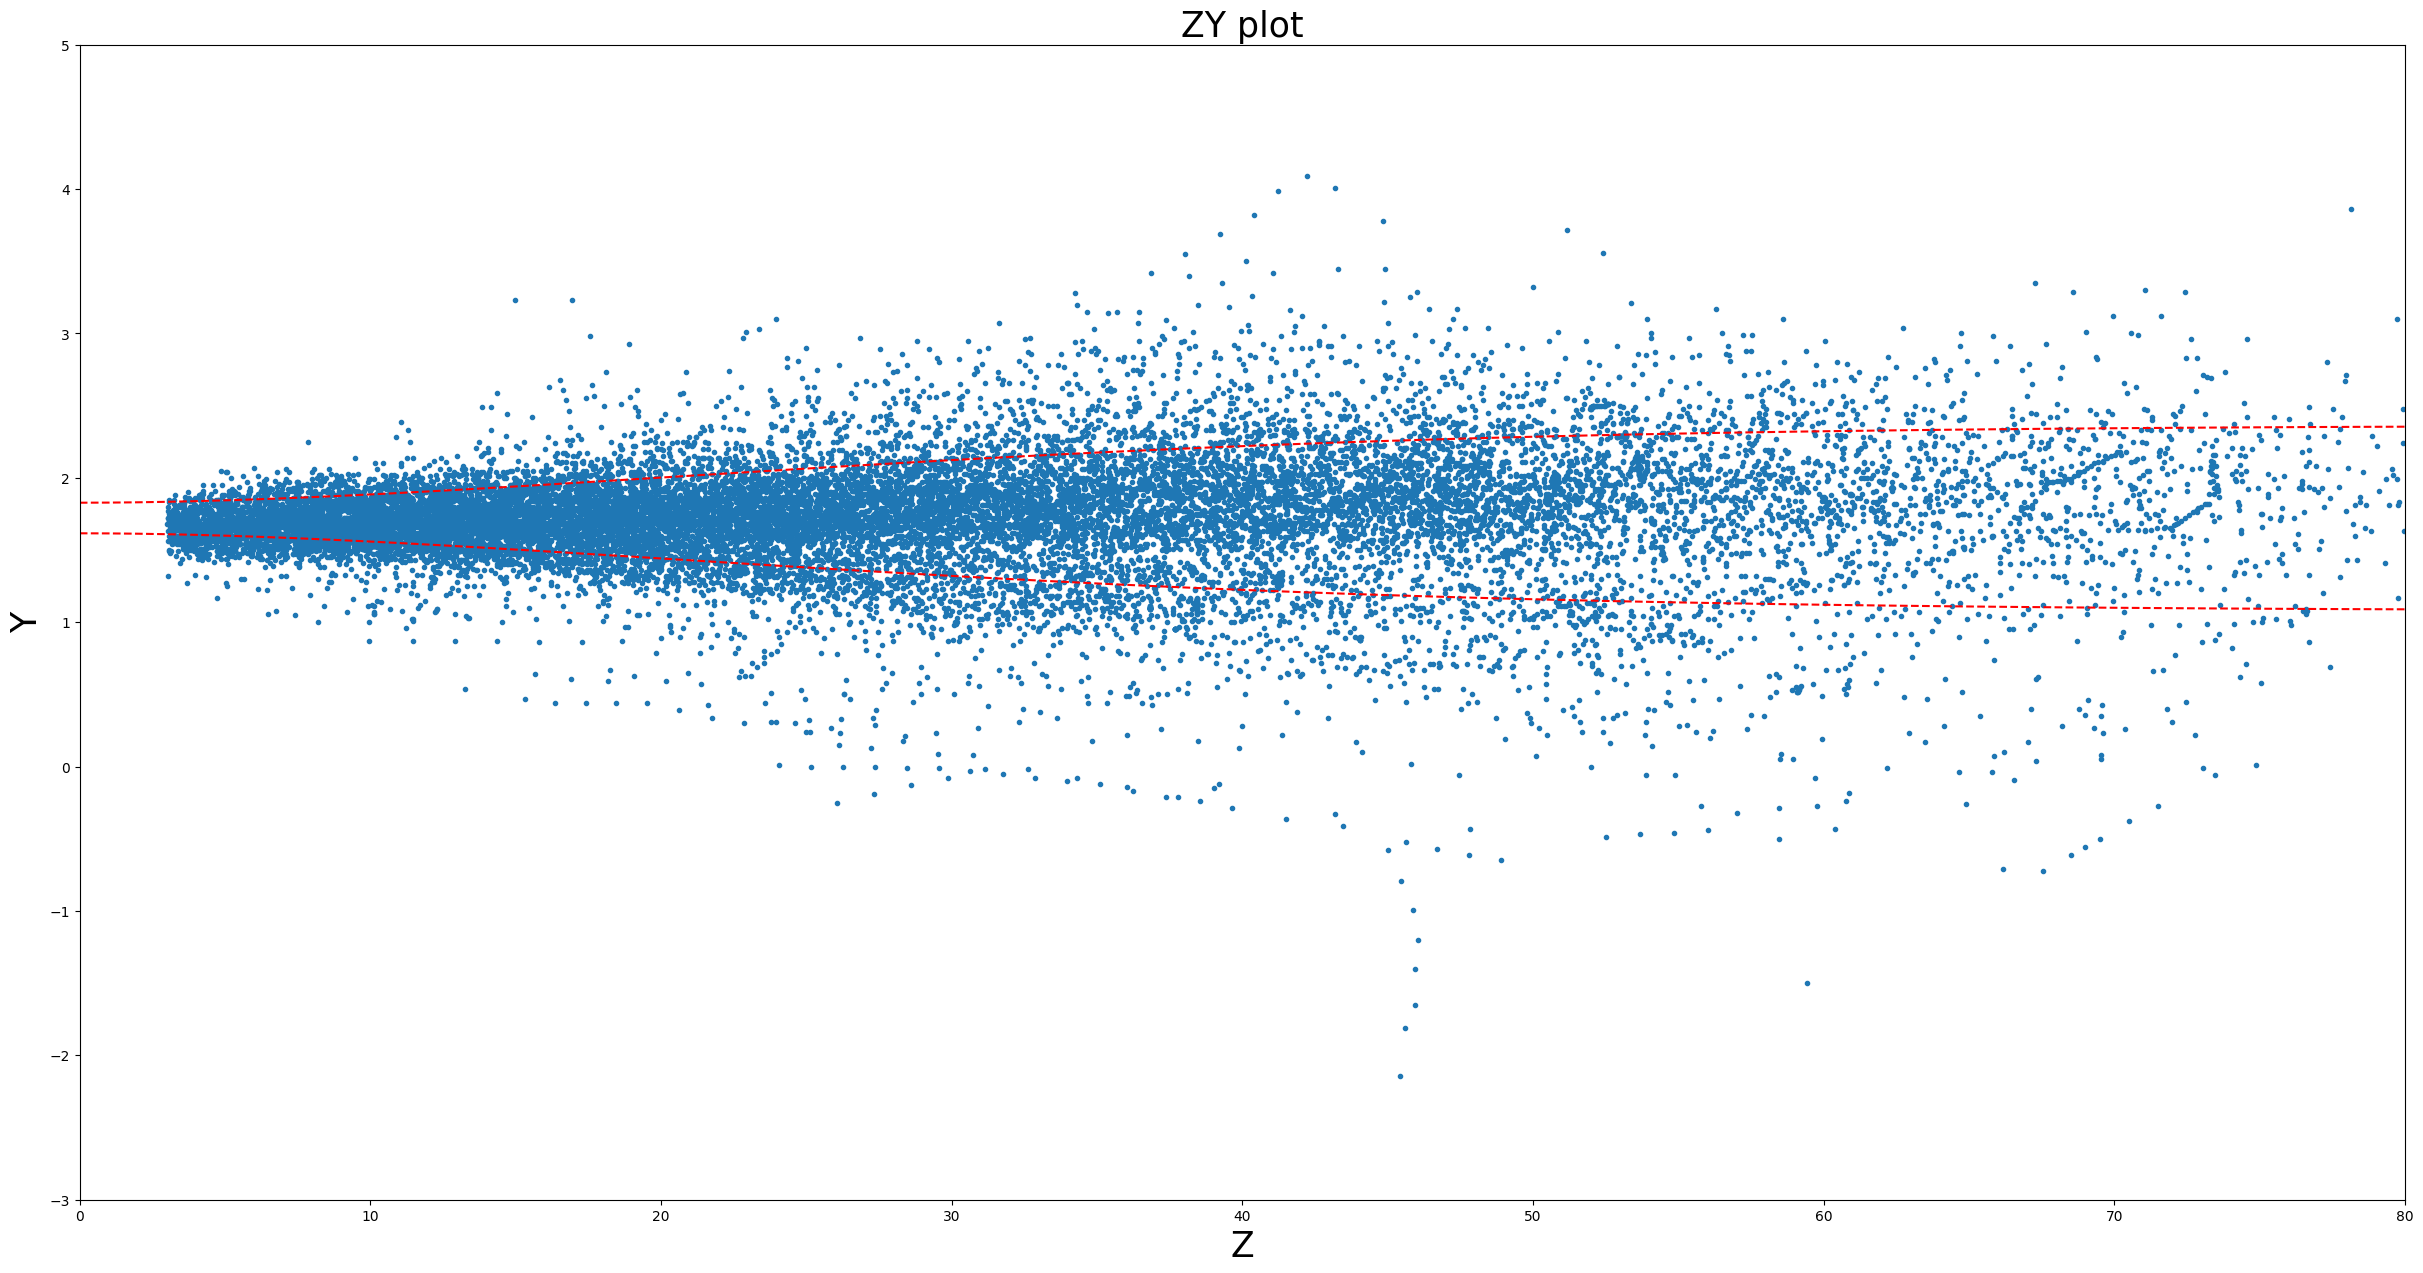

In [5]:


# Draw y slope of Adpative Anchor
# Prepare upper bound and lower bound sample
N_SAMPLE = 1000

z_samples = []
upp_samples = []
dnp_samples = []
for z in np.arange(0, 80, 80/N_SAMPLE):
    z_samples.append(z)
    upp_samples.append(func(z, *popt_upper) )
    dnp_samples.append(func(z, *popt_lower) )
z_samples   = np.array(z_samples)
upp_samples = np.array(upp_samples)
dnp_samples = np.array(dnp_samples)

anchors_tensor = []
for y_f_idx in range(18):
    
    # Get slope
    cy = y_f_idx * 16 + 8
    slope = (cy - P2_tf[1, 2]) / P2_tf[1, 1]

    # Find intersection of upper bound and lower bound
    y_up_diff = upp_samples - (slope*z_samples + AVG_HEIGT/2)
    y_lo_diff = dnp_samples - (slope*z_samples + AVG_HEIGT/2)
    z_up_inter_idx = np.where(np.sign(y_up_diff[:-1]) != np.sign(y_up_diff[1:]))[0] + 1 # Find sign change
    z_lo_inter_idx = np.where(np.sign(y_lo_diff[:-1]) != np.sign(y_lo_diff[1:]))[0] + 1 # Find sign change

    # Deal with 'no solution' and limit z range to [0, 80]
    if len(z_lo_inter_idx) == 0:
        lb = 0
        rb = 80
    else:
        lb = ( z_samples[z_lo_inter_idx] + z_samples[z_lo_inter_idx-1] )[0] / 2
        if len(z_up_inter_idx) == 0:
            rb = 80
        else:
            rb = ( z_samples[z_up_inter_idx] + z_samples[z_up_inter_idx-1] )[0] / 2

    print(f"z left&right boundary = {(lb, rb)}")

    if IS_SIDE_CHANNEL:
        z_stride = (rb - lb)/(N_ANCHOR_PER_PIXEL/3)
    else:
        z_stride = (rb - lb)/ N_ANCHOR_PER_PIXEL

    # This is for visuzliation
    z_plot = []
    y_plot = []

    for x_f_idx in range(80):
        cx = x_f_idx * 16 + 8
        
        for cz_base in np.arange(lb, rb, z_stride):

            if IS_SIDE_CHANNEL:
                offset_list = [(0, 0), 
                               (z_stride*1/3, (upp_samples[int((cz_base + z_stride*1/3)/N_SAMPLE)] - y_mean)*1.0),
                               (z_stride*2/3, (dnp_samples[int((cz_base + z_stride*2/3)/N_SAMPLE)] - y_mean)*1.0)]
            else:
                offset_list = [(0, 0)]
            
            for cz_offset, y3d_offset in offset_list:
                
                # Convert (cx, cy, cz) to (x3d, y3d, z3d)
                cz = cz_base + cz_offset
                loc_3d = np.linalg.inv(P2_tf[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
                loc_3d[1, 0] += AVG_HEIGT / 2.0
                loc_3d[1, 0] += y3d_offset

                # Get observation angle: alpha
                rot_y = pi/2
                alpha = rot_y + atan2(loc_3d[2, 0], loc_3d[0, 0]) - pi/2
                
                # alpha in [-pi, pi]
                if   alpha >  pi: alpha -= 2*pi
                elif alpha < -pi: alpha += 2*pi

                # l, h, w = dimension
                corner_2D = get_corner_2D(P2_tf, (loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0]), rot_y, (AVG_LENTH, AVG_HEIGT, AVG_WIDTH))

                # Get x1, y1, x2 ,y2
                x1 = corner_2D[0].min()
                y1 = corner_2D[1].min()
                x2 = corner_2D[0].max()
                y2 = corner_2D[1].max()

                # 
                anchors_tensor.append([x1, y1, x2, y2, 0, cx, cy, cz, AVG_WIDTH, AVG_HEIGT, AVG_LENTH, alpha, loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0], rot_y])

                # 
                z_plot.append(loc_3d[2, 0])
                y_plot.append(loc_3d[1, 0])
    
    # Draw blue lines (main channel)
    axs[0].plot(list(np.arange(lb, rb, (rb-lb)/N_SAMPLE)), [slope*i + AVG_HEIGT/2 for i in np.arange(lb, rb, (rb-lb)/N_SAMPLE)], 'b')
    
    # # Draw Red dot 
    # axs[0].plot(list(np.arange(lb, rb, (rb-lb)/N_ANCHOR_PER_PIXEL)), [slope*i + AVG_HEIGT/2 for i in np.arange(lb, rb, (rb-lb)/N_ANCHOR_PER_PIXEL)], 'r*')

    # # Draw gree line (side channel)
    # axs[0].plot(list(np.arange(lb, rb, (rb-lb)/N_SAMPLE)), [slope*i + AVG_HEIGT/2 + (func(i, *popt_upper) - y_mean)*0.333 for i in np.arange(lb, rb, (rb-lb)/N_SAMPLE)], 'lime')
    # axs[0].plot(list(np.arange(lb, rb, (rb-lb)/N_SAMPLE)), [slope*i + AVG_HEIGT/2 - (func(i, *popt_upper) - y_mean)*0.333 for i in np.arange(lb, rb, (rb-lb)/N_SAMPLE)], 'lime')

    # Draw anchor on ZY distribution
    axs[0].plot(z_plot, y_plot, 'r*')


anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]



# Output anchor

In [ ]:
%%script false --no-raise-error

with open(f"pkl/{ANCHOR_NAME}.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to {ANCHOR_NAME}.pkl")

# Get anchor_map
heat_data = np.zeros(shape=(18, 80))
for a in anchors_tensor:
    heat_data[int(a[6]/16), int(a[5]/16)] += 1
max_n_anchor = int(heat_data.max())
anchor_map = []
for i in range(18):
    for j in range(80):
        anchor_map += ( [True for _ in range(int(heat_data[i, j]))] + [False for _ in range(max_n_anchor - int(heat_data[i, j]))] )
anchor_map = torch.tensor(anchor_map)


print( f"Total number of anchor = {anchor_map.shape}" ) # [46080] trues
print( f"Number of useful anchor = {torch.count_nonzero(anchor_map)}" )

with open(f"pkl/{ANCHOR_NAME}_map.pkl", 'wb') as f:
    pickle.dump(anchor_map, f)
print(f"Write anchor result to {ANCHOR_NAME}_map.pkl")

Write anchor result to anchors_adaptive.pkl
Total number of anchor = torch.Size([46080])
Number of useful anchor = 46080
Write anchor result to anchors_adaptive_map.pkl
